In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

from torch.optim.lr_scheduler import StepLR


In [40]:
# Reproducibilidad y dispositivo
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

## 1) Data — split estratificado + transforms (augment solo en train)

In [41]:
# Ruta del dataset 
DATASET_PATH = os.path.join('datasets', 'real_and_fake_face')

# Transforms
train_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

test_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

In [42]:
# Cargamos una sola vez para obtener labels y estratificar
full = datasets.ImageFolder(root=DATASET_PATH, transform=None)
classes = full.classes  # nombres de clases
targets = [y for _, y in full.samples]  

# Split estratificado 70/30
idx_train, idx_test = train_test_split(
    np.arange(len(full)),
    test_size=0.3,
    random_state=SEED,
    stratify=targets
)

# Subsets con transforms distintos (augment solo en train)
train_set = Subset(datasets.ImageFolder(DATASET_PATH, transform=train_tf), idx_train)
test_set  = Subset(datasets.ImageFolder(DATASET_PATH, transform=test_tf),  idx_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

len(train_set), len(test_set), classes


(1428, 613, ['fake', 'real'])

# CNN baseline

In [43]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2,2)
        # 256x256 -> pool -> 128x128 -> pool -> 64x64
        self.fc1   = nn.Linear(64*64*64, 128)
        self.fc2   = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), 0.1))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), 0.1))
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.fc2(x)
        return x


In [44]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    run_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        pred = torch.argmax(logits, dim=1)
        total += y.size(0)
        correct += (pred == y).sum().item()
    return run_loss / max(1,len(loader)), correct / max(1,total)


In [45]:
def evaluate(model, loader, class_names):
    model.eval()
    all_y, all_p = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            all_p.extend(pred)
            all_y.extend(y.numpy())

    acc = accuracy_score(all_y, all_p)
    p, r, f1, _ = precision_recall_fscore_support(all_y, all_p, average='binary')
    print(f"Test — Acc: {acc:.4f} | Prec: {p:.4f} | Rec: {r:.4f} | F1: {f1:.4f}")
    print(classification_report(all_y, all_p, target_names=class_names))

    cm = confusion_matrix(all_y, all_p)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix'); plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)
    th = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color="white" if cm[i, j] > th else "black")
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout()
    plt.show()


In [46]:
def visualize_predictions(model, loader, num_images=12, num_cols=4, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]):
    model.eval()
    inv_mean = [-m/s for m, s in zip(mean, std)]
    inv_std  = [1.0/s for s in std]
    inv_norm = transforms.Normalize(mean=inv_mean, std=inv_std)

    shown = 0
    rows = int(np.ceil(num_images / num_cols))
    fig, ax = plt.subplots(rows, num_cols, figsize=(4*num_cols, 3*rows))
    if rows == 1: ax = np.expand_dims(ax, 0)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            pred = torch.argmax(logits, dim=1).cpu()
            y = y.cpu()
            for j in range(x.size(0)):
                if shown >= num_images:
                    plt.tight_layout(); plt.show(); return
                r = shown // num_cols
                c = shown % num_cols
                img = inv_norm(x[j].cpu()).clamp(0,1)
                ax[r,c].imshow(np.transpose(img.numpy(), (1,2,0)))
                ax[r,c].axis('off')
                ax[r,c].set_title(f"True: {y[j].item()} | Pred: {pred[j].item()}")
                shown += 1
    plt.tight_layout(); plt.show()


## Bucle de entrenamiento

In [47]:
# Entrenamiento CNN baseline
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS = 15
history_loss, history_acc = [], []

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer)
    scheduler.step()
    history_loss.append(tr_loss); history_acc.append(tr_acc)
    print(f"Epoch [{ep}/{EPOCHS}] | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc*100:.2f}%")


Epoch [1/15] | Train Loss: 13.0223 | Train Acc: 52.03%
Epoch [2/15] | Train Loss: 1.6968 | Train Acc: 57.49%
Epoch [3/15] | Train Loss: 2.2135 | Train Acc: 55.04%
Epoch [4/15] | Train Loss: 1.6108 | Train Acc: 57.56%
Epoch [5/15] | Train Loss: 1.3328 | Train Acc: 60.78%
Epoch [6/15] | Train Loss: 1.0830 | Train Acc: 62.11%
Epoch [7/15] | Train Loss: 0.7645 | Train Acc: 67.37%
Epoch [8/15] | Train Loss: 0.9271 | Train Acc: 64.22%
Epoch [9/15] | Train Loss: 1.2504 | Train Acc: 60.29%
Epoch [10/15] | Train Loss: 0.8634 | Train Acc: 66.46%
Epoch [11/15] | Train Loss: 0.6726 | Train Acc: 69.54%
Epoch [12/15] | Train Loss: 0.6694 | Train Acc: 70.59%
Epoch [13/15] | Train Loss: 0.6442 | Train Acc: 69.26%
Epoch [14/15] | Train Loss: 0.5423 | Train Acc: 74.37%
Epoch [15/15] | Train Loss: 0.5528 | Train Acc: 74.44%


## Curvas de entrenamiento

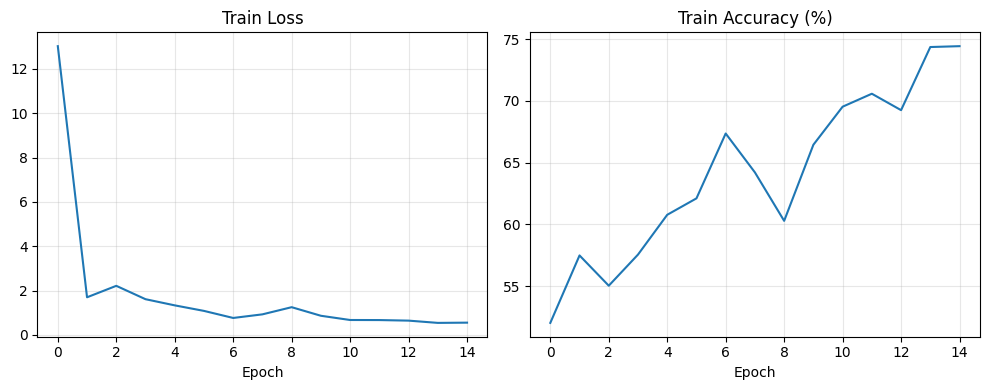

In [48]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history_loss); plt.title('Train Loss'); plt.xlabel('Epoch'); plt.grid(alpha=.3)
plt.subplot(1,2,2); plt.plot(np.array(history_acc)*100); plt.title('Train Accuracy (%)'); plt.xlabel('Epoch'); plt.grid(alpha=.3)
plt.tight_layout(); plt.show()


## Evaluación completa

Test — Acc: 0.5595 | Prec: 0.5532 | Rec: 0.8800 | F1: 0.6793
              precision    recall  f1-score   support

        fake       0.59      0.20      0.30       288
        real       0.55      0.88      0.68       325

    accuracy                           0.56       613
   macro avg       0.57      0.54      0.49       613
weighted avg       0.57      0.56      0.50       613



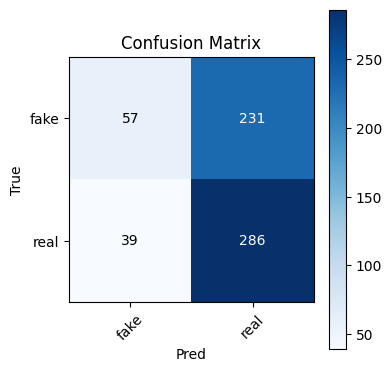

In [49]:
evaluate(model, test_loader, classes)

## Visualización

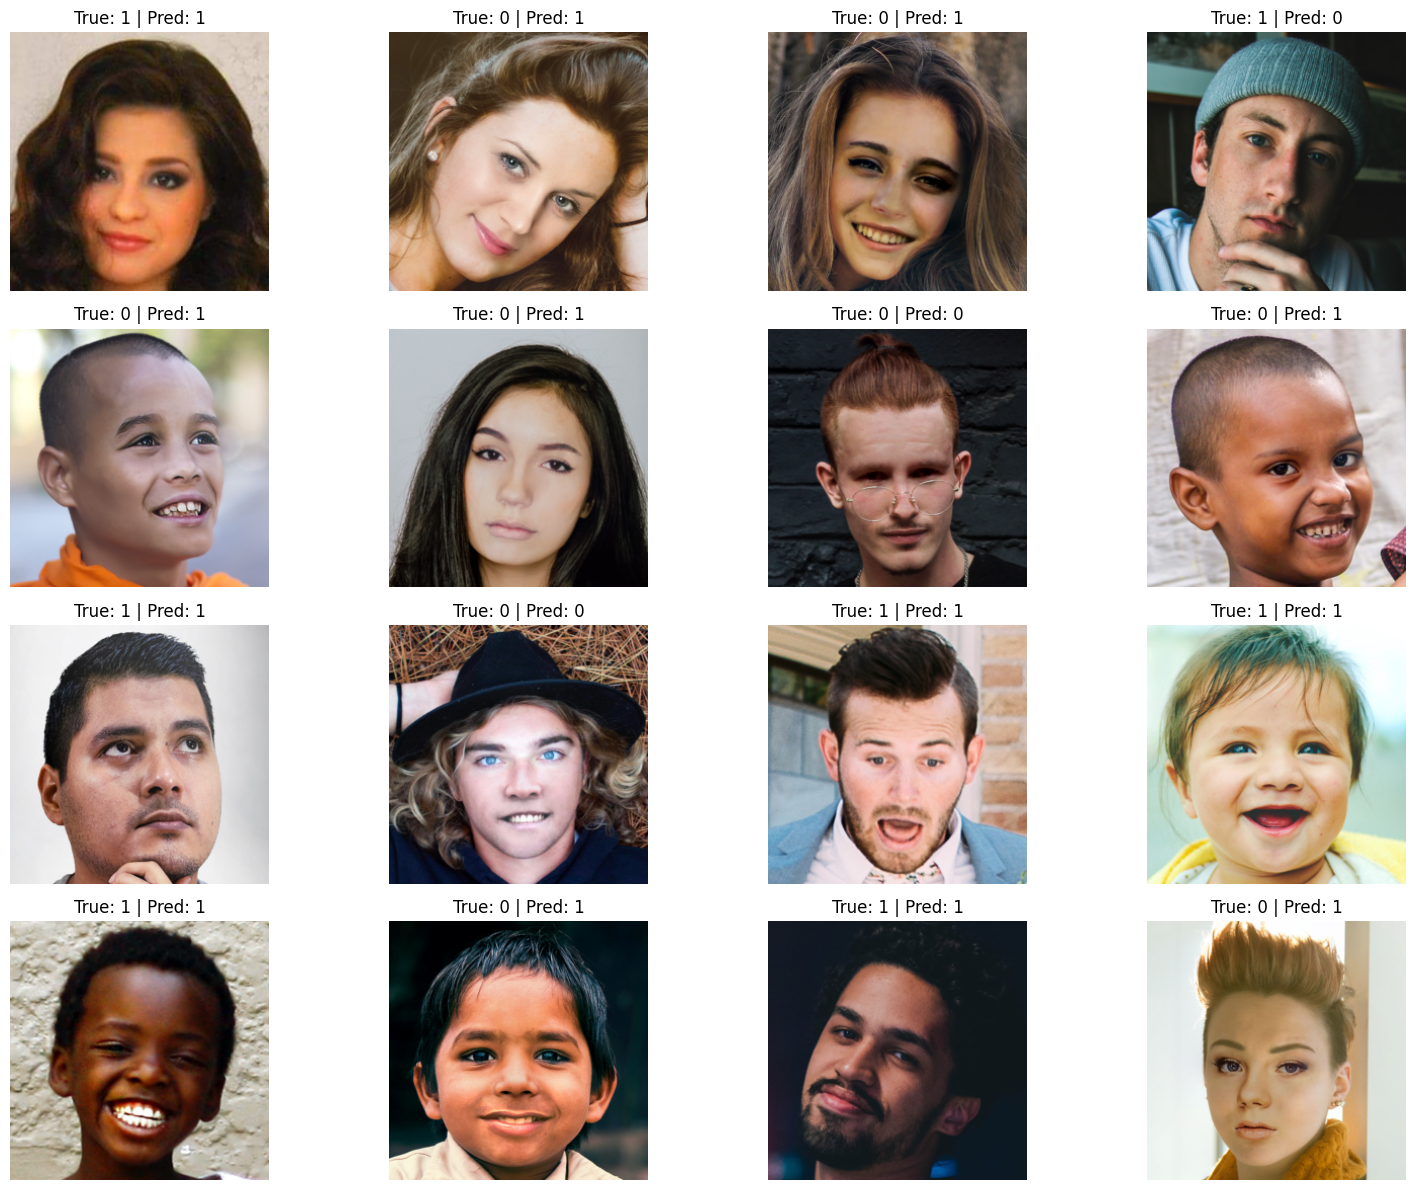

In [50]:
visualize_predictions(model, test_loader, 16, 4, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])

# MobileNetV2 (pretrained, torchvision)

In [51]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

weights = MobileNet_V2_Weights.DEFAULT

# Normalización de ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_tf_m = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

test_tf_m = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


In [52]:
class MobileNetV2Finetune(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.backbone = mobilenet_v2(weights=weights)
        in_feat = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_feat, 2)
        )
    def forward(self, x):
        return self.backbone(x)


In [53]:
# Se reutiliza el mismo split estratificado (idx_train / idx_test) para ser consistente
train_set_m = Subset(datasets.ImageFolder(DATASET_PATH, transform=train_tf_m), idx_train)
test_set_m  = Subset(datasets.ImageFolder(DATASET_PATH, transform=test_tf_m),  idx_test)

train_loader_m = DataLoader(train_set_m, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
test_loader_m  = DataLoader(test_set_m,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Modelo MobileNetV2 preentrenado en ImageNet
model_m = mobilenet_v2(weights=weights)
in_feat = model_m.classifier[1].in_features
model_m.classifier[1] = nn.Linear(in_feat, 2)
model_m = model_m.to(device)  

# Optimizador y scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_m.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Entrenamiento
EPOCHS = 15
history_loss_m, history_acc_m = [], []

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model_m, train_loader_m, criterion, optimizer)
    scheduler.step()
    history_loss_m.append(tr_loss)
    history_acc_m.append(tr_acc)
    print(f"Epoch [{ep}/{EPOCHS}] | Loss={tr_loss:.4f} | Acc={tr_acc*100:.2f}%")

Epoch [1/15] | Loss=0.6634 | Acc=60.92%
Epoch [2/15] | Loss=0.5795 | Acc=70.24%
Epoch [3/15] | Loss=0.4764 | Acc=76.89%
Epoch [4/15] | Loss=0.4255 | Acc=80.60%
Epoch [5/15] | Loss=0.3451 | Acc=85.29%
Epoch [6/15] | Loss=0.2313 | Acc=91.53%
Epoch [7/15] | Loss=0.1673 | Acc=94.26%
Epoch [8/15] | Loss=0.1180 | Acc=96.22%
Epoch [9/15] | Loss=0.1031 | Acc=96.08%
Epoch [10/15] | Loss=0.0738 | Acc=97.48%
Epoch [11/15] | Loss=0.0640 | Acc=97.97%
Epoch [12/15] | Loss=0.0652 | Acc=97.90%
Epoch [13/15] | Loss=0.0669 | Acc=98.18%
Epoch [14/15] | Loss=0.0498 | Acc=98.95%
Epoch [15/15] | Loss=0.0616 | Acc=97.90%


## Curvas de entrenamiento

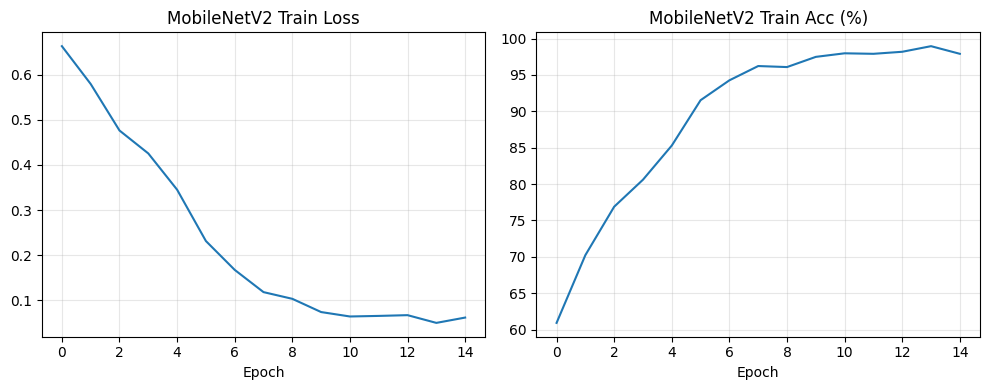

In [54]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history_loss_m); plt.title('MobileNetV2 Train Loss'); plt.xlabel('Epoch'); plt.grid(alpha=.3)
plt.subplot(1,2,2); plt.plot(np.array(history_acc_m)*100); plt.title('MobileNetV2 Train Acc (%)'); plt.xlabel('Epoch'); plt.grid(alpha=.3)
plt.tight_layout(); plt.show()

## Evaluación completa

Test — Acc: 0.7635 | Prec: 0.7500 | Rec: 0.8308 | F1: 0.7883
              precision    recall  f1-score   support

        fake       0.78      0.69      0.73       288
        real       0.75      0.83      0.79       325

    accuracy                           0.76       613
   macro avg       0.77      0.76      0.76       613
weighted avg       0.77      0.76      0.76       613



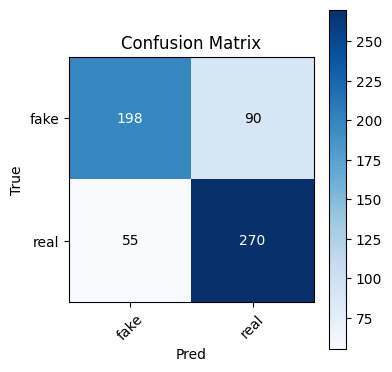

In [55]:
evaluate(model_m, test_loader_m, classes)

## Visualización

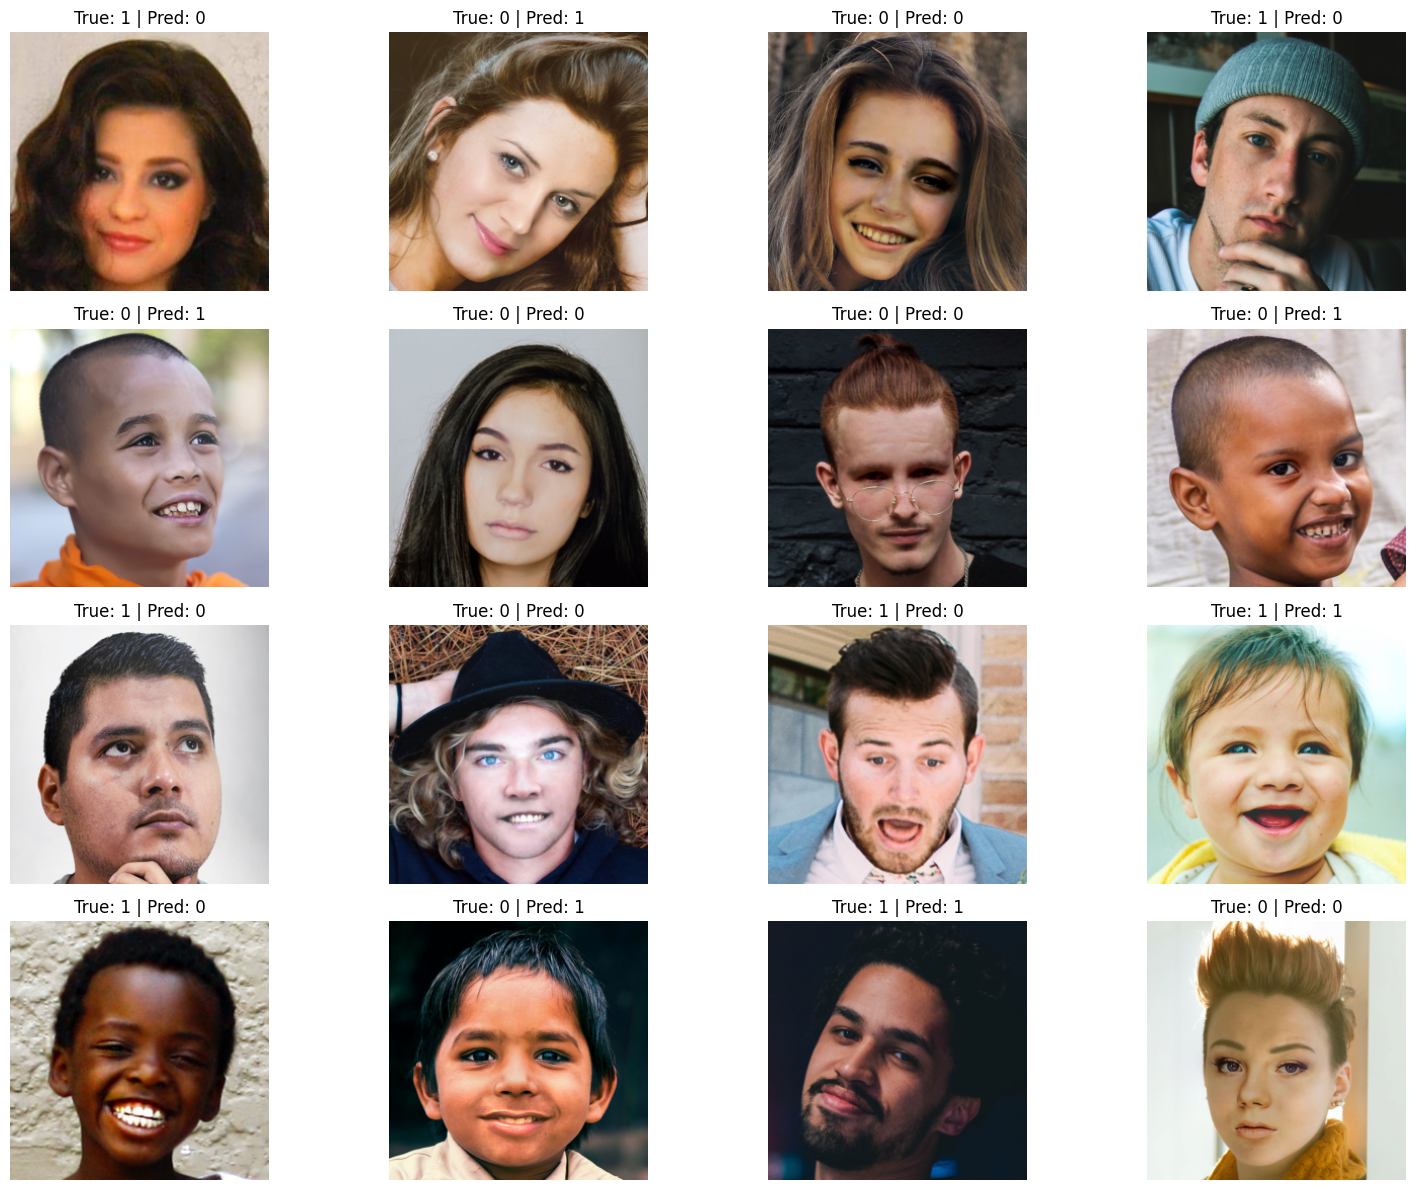

In [56]:
visualize_predictions(model_m, test_loader_m, num_images=16, num_cols=4, mean=imagenet_mean, std=imagenet_std)